In [1]:
"""
Bidirectional LSTMS on VOXELS

Usage:

- extract_path is the where the extracted data samples are available.
- checkpoint_model_path is the path where to checkpoint the trained models during the training process


EXAMPLE: SPECIFICATION

extract_path = '/Users/sandeep/Research/Ti-mmWave/data/extract/Train_Data_voxels_'
checkpoint_model_path="/Users/sandeep/Research/Ti-mmWave/data/extract/LSTM"
"""

extract_path = '/home/wt/RadHAR/Data/extract/Train_Data_voxels_'
checkpoint_model_path="/home/wt/RadHAR/Data/model"


import glob
import os
import numpy as np
# random seed.
rand_seed = 1
from numpy.random import seed
seed(rand_seed)
#from tensorflow import set_random_seed
#set_random_seed(rand_seed)
import tensorflow
tensorflow.random.set_seed(rand_seed)

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Bidirectional,TimeDistributed
from sklearn.model_selection import train_test_split
from keras.models import load_model


sub_dirs=['stand','swing']

def one_hot_encoding(y_data, sub_dirs, categories):
    Mapping=dict()

    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        Type = Type.decode('utf-8')
        lab=Mapping[Type]
        #lab = Mappin.get(Type)
        
        y_features2.append(lab)
    
    y_features=np.array(y_features2)
    #print(y_features.shape)
    y_features=y_features.reshape(y_features.shape[0],1)
    
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)
    print(y_features.shape)
    return y_features


def full_3D_model(summary=False):
    print('building the model ... ')
    model = Sequential()

    model.add(Bidirectional(LSTM(64, return_sequences=False, stateful=False,input_shape=(60, 10*1024) )))
    model.add(Dropout(.5,name='dropout_1'))
    model.add(Dense(128, activation='relu', name='DENSE_1'))
    model.add(Dropout(.5,name='dropout_2'))
    model.add(Dense(2, activation='softmax', name = 'output'))

    return model



frame_tog = [60]


#loading the train data
Data_path = extract_path+'stand'

data = np.load(Data_path+'.npz')
train_data = data['arr_0']
train_data = np.array(train_data,dtype=np.dtype(np.int32))
train_label = data['arr_1']
#print(train_label.shape)
del data
print(train_data.shape,train_label.shape)

Data_path = extract_path+'swing'
data = np.load(Data_path+'.npz')
train_data = np.concatenate((train_data, data['arr_0']), axis=0)
train_label = np.concatenate((train_label, data['arr_1']), axis=0)


del data

print(train_data.shape,train_label.shape)




train_label = one_hot_encoding(train_label, sub_dirs, categories=2)

train_data = train_data.reshape(train_data.shape[0],train_data.shape[1], train_data.shape[2]*train_data.shape[3]*train_data.shape[4])

print('Training Data Shape is:')
print(train_data.shape,train_label.shape)

#indices = []
indices =np.zeros([train_label.shape[0],1])
#print("train label shape: " + train_label.shape)
for index in range(train_label.shape[0]):
    indices[index,0] = index
    #indices[index]=index
print("after append")
print(indices.shape)


X_train, X_val, y_train, y_val, indices_train, indices_test  = train_test_split(train_data, train_label, indices, test_size=0.20, random_state=1)
del train_data,train_label

##shuffle before use validation split
from sklearn.utils import shuffle
#np.random.shuffle(X_train)
#y_train[X_train[:,0]]
X_train, y_train = shuffle(X_train, y_train)

model = full_3D_model()


print("Model building is completed")


adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None,
                       decay=0.0, amsgrad=False)

model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=adam,
                  metrics=['accuracy'])

checkpoint = ModelCheckpoint(checkpoint_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]








(41, 60, 10, 32, 32) (41,)
(129, 60, 10, 32, 32) (129,)
(129, 2)
Training Data Shape is:
(129, 60, 10240) (129, 2)
after append
(129, 1)
building the model ... 
Model building is completed


In [2]:
##training data
import time

timestamp = time.time()

# Training the model
learning_hist = model.fit(X_train, y_train,
                             batch_size=20,
                             epochs=30,
                             verbose=1,
                             shuffle=True,
                             validation_split = 0.2,
                           #validation_data=(X_val,y_val),
                             
                           callbacks=callbacks_list
                          )

finish_timestamp = time.time()

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

4/4 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.5410
Epoch 00001: val_loss improved from inf to 0.67807, saving model to /home/wt/RadHAR/Data/model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/wt/RadHAR/Data/model/assets
4/4 [==============================] - 9s 2s/step - loss: 0.6863 - accuracy: 0.5410 - val_loss: 0.6781 - val_accuracy: 0.6875
Epoch 2/30
4/4 [=============================

Epoch 23/30
4/4 [==============================] - ETA: 0s - loss: 8.0663e-05 - accuracy: 1.0000
Epoch 00023: val_loss did not improve from 0.18963
4/4 [==============================] - 1s 266ms/step - loss: 8.0663e-05 - accuracy: 1.0000 - val_loss: 0.1920 - val_accuracy: 0.9375
Epoch 24/30
4/4 [==============================] - ETA: 0s - loss: 7.2840e-05 - accuracy: 1.0000
Epoch 00024: val_loss did not improve from 0.18963
4/4 [==============================] - 1s 263ms/step - loss: 7.2840e-05 - accuracy: 1.0000 - val_loss: 0.1933 - val_accuracy: 0.9375
Epoch 25/30
4/4 [==============================] - ETA: 0s - loss: 7.1293e-05 - accuracy: 1.0000
Epoch 00025: val_loss did not improve from 0.18963
4/4 [==============================] - 1s 266ms/step - loss: 7.1293e-05 - accuracy: 1.0000 - val_loss: 0.1943 - val_accuracy: 0.9375
Epoch 26/30
4/4 [==============================] - ETA: 0s - loss: 1.7397e-04 - accuracy: 1.0000
Epoch 00026: val_loss did not improve from 0.18963
4/4 [====

In [3]:
#calculate time

timestruct = time.localtime(finish_timestamp - timestamp)
print(time.strftime('%H:%M:%S', timestruct))
#print(finish_timestamp - timestamp)
#print(time.strftime('%Y-%m-%d %H:%M:%S', timestruct))

08:01:55


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


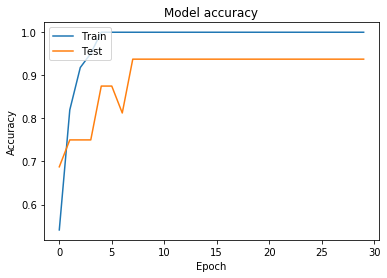

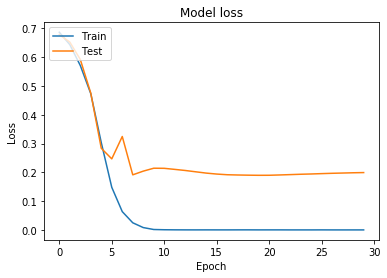

Evaluate on test data
3/3 [==============================] - 0s 48ms/step - loss: 1.8005e-05 - accuracy: 1.0000
test loss, test acc: [1.8004955563810654e-05, 1.0]
(52, 2)
122.0
104.0
55.0
56.0
33.0
119.0
123.0
35.0
31.0
51.0
115.0
103.0
4.0
67.0
102.0
48.0
46.0
59.0
92.0
127.0
126.0
2.0
53.0
117.0
111.0
114.0
80.0
44.0
99.0
54.0
83.0
17.0
88.0
74.0
121.0
45.0
77.0
105.0
97.0
58.0
42.0
66.0
85.0
10.0
62.0
32.0
108.0
38.0
19.0
128.0
27.0
36.0


In [4]:
##show the history
import matplotlib.pyplot as plt

print(learning_hist.history.keys())
# 绘制训练 & 验证的准确率值
plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_val, y_val, batch_size=20)
print("test loss, test acc:", results)
print(y_val.shape)
for i in range(y_val.shape[0]):
    print(indices_test[i][0])


In [5]:
## Saving the model

model.save( checkpoint_model_path + '/LSTM.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
print("save complete")


save complete


In [6]:
del model